In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import yfinance as yf
import pymc as pm
import arviz as az
import os
import jax
jax.config.update("jax_enable_x64", False)
from scipy.fft import fft, fftfreq
from arch import arch_model

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# from Yahoo Finance API, I am downloading AAPL stock prices
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2023-01-01", end="2023-12-31")
stock_prices = data["Adj Close"]

stock_prices.info()
# stock_prices.shape

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


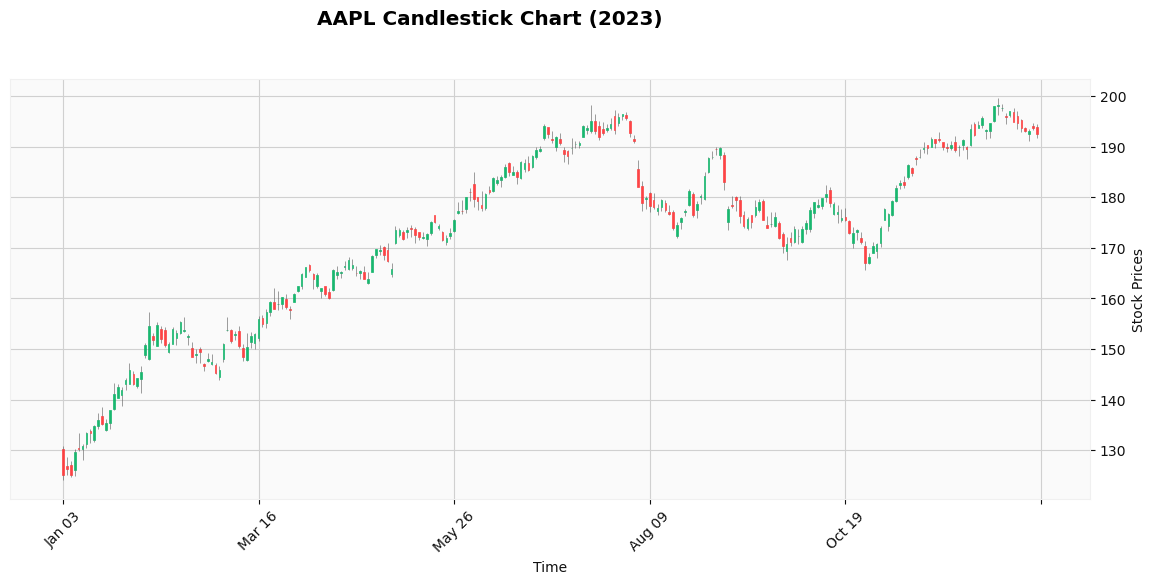

In [3]:
# without this it throws ValueError
data.columns = data.columns.get_level_values(0)

# Stock prices data analysis is incomplete without a candlestick chart! XD
# plotting candlestick chart using mplfinance package
mpf.plot(
    data,
    type="candle",
    style="yahoo",
    title="AAPL Candlestick Chart (2023)",
    ylabel="Stock Prices",
    xlabel="Time",
    show_nontrading=False,
    figsize=(15, 6)
)

In [4]:
# Standardizing is completely optional
# Since the dataset is huge, so to avoid divergences, I am standardizing the stock prices

stock_prices_standardized = (stock_prices - stock_prices.mean()) / (2 * stock_prices.std())
stock_prices_standardized.shape
print("Shape before: ", stock_prices_standardized.shape)

# since the shape isn't 1D so there's a need to squeeze it so as to plot it
stock_prices_standardized = stock_prices_standardized.squeeze()

# Check the data's dimensions and type
print("Shape after: ", stock_prices_standardized.shape)

Shape before:  (250, 1)
Shape after:  (250,)


# STL Decomposition

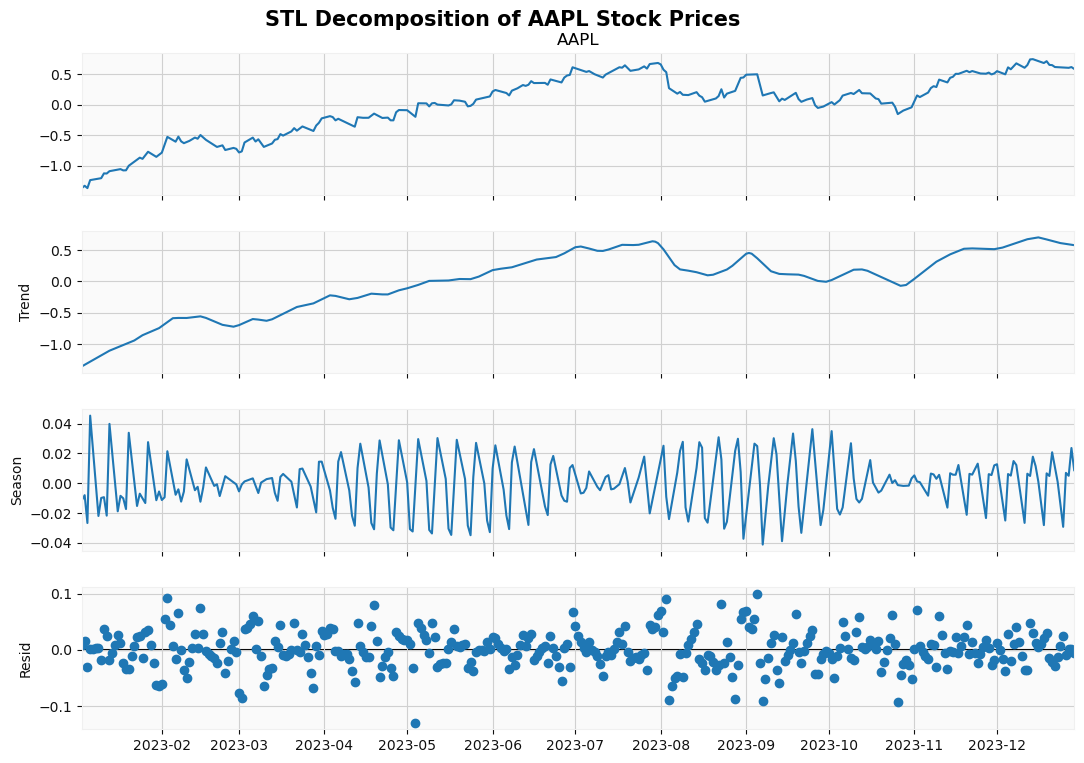

((361,), (361,), (361,), (361,))

In [5]:
# For STL decomposition, there must not be missing values.
# so with the reference of previous and next days' data, interpolating the missing values 
stock_prices_standardized = stock_prices_standardized.asfreq('D')
stock_prices_standardized = stock_prices_standardized.interpolate()

# for decomposition, I am taking 13 as seasonal leangth (7 is default)
stl = STL(stock_prices_standardized, seasonal=13)
result = stl.fit()
stl_decomp = result.plot()
stl_decomp.set_size_inches(12, 8)
plt.suptitle("STL Decomposition of AAPL Stock Prices", fontsize=15)
plt.show()

# performing 3 types of analysis, (later in the code)
# so I need trend, seasonal and residuals components for the models
trend = result.trend
seasonal = result.seasonal
residuals = result.resid

trend.shape, seasonal.shape, residuals.shape, stock_prices_standardized.shape

# Trends Analysis using Gaussian Process Model

In [6]:
with pm.Model() as trends_model:
    
    ls = pm.Gamma("length_scale", alpha=2, beta=1)
    eta = pm.Gamma("eta", alpha=2, beta=1)
    noise = pm.HalfNormal("noise", sigma=0.1)
    
#     covariance function
#     adding amplitude to smooth the curve and ignore the extra noise
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ls)
    
    gauss = pm.gp.Marginal(cov_func=cov_func)
    
    trends = gauss.marginal_likelihood("trends", X=np.arange(len(trend))[:, None], y=trend.values, noise=noise)
    
    trace = pm.sample(500, tune=200, return_inferencedata=True, nuts_sampler="numpyro")
    
#     I tried doing this explicitely, but I was running into errors, so including it in the model
#     pm.sample_posterior_predictive does not have any arguments to set number of samples
#     and it is taking 2000 samples by default in the case
#     since the data is too big, it takes forever to run the code. so using thin_trace to consider every 20th sample
#     this divides the samples and it takes only 100 samples
    thin_trace = trace.posterior.isel(draw=slice(0, None, 20))
    samples = pm.sample_posterior_predictive(thin_trace, var_names=["trends"], predictions=True)

    
#     fetching the posterior means and stds to use it in plots in later analysis
    post_mean = samples.predictions["trends"].mean(axis=0)
    post_std = samples.predictions["trends"].std(axis=0)

C:\Users\eshik\anaconda3\lib\site-packages\pymc\gp\gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Sampling: [trends]


In [7]:
az.summary(trace, hdi_prob=0.95)

C:\Users\eshik\anaconda3\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
length_scale,6.470,0.097,6.269,6.649,0.003,0.002,1244.0,1423.0,1.0
eta,0.384,0.037,0.311,0.455,0.001,0.001,1234.0,1434.0,1.0
noise,0.001,0.000,0.001,0.001,0.000,0.000,1376.0,1094.0,1.0


mean shape before: (25, 361)
std shape before: (25, 361)
mean shape after: (361,)
std shape after: (361,)
trend shape:  (361,)


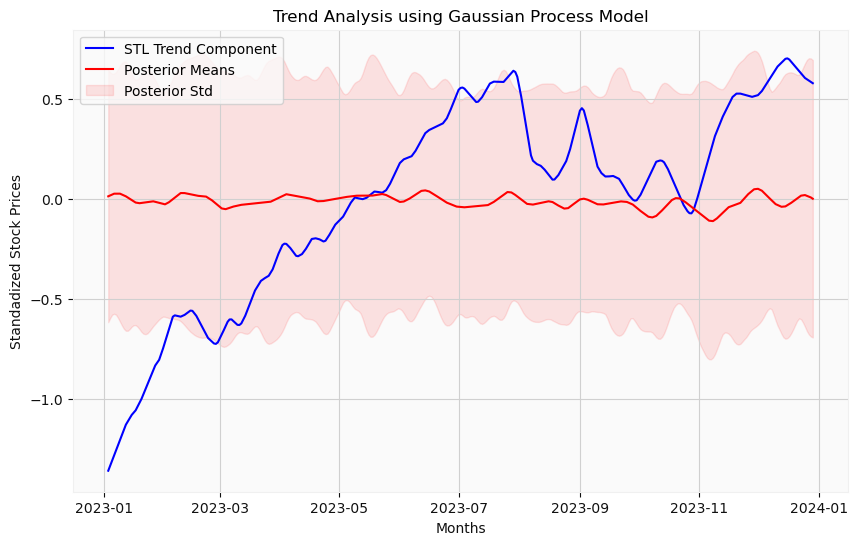

In [8]:
# now plotting the model's predictions and analysing the plots

post_mean = samples.predictions["trends"].mean(axis=0)
post_std = samples.predictions["trends"].std(axis=0)  

print("mean shape before:", post_mean.shape)
print("std shape before:", post_std.shape)

# since the shape is not 1D, there's a need to convert it to 1D and then plot it
# as the plot is not accepting multi dimensional data, it needs to be in 1D
post_mean = post_mean.mean(axis=0)
post_std = post_std.mean(axis=0)

print("mean shape after:", post_mean.shape)
print("std shape after:", post_std.shape)

# now it is 1D. Yayy!!

trend = result.trend
print("trend shape: ",trend.shape)
# Plot the trend with uncertainty bands
plt.figure(figsize=(10, 6))
plt.plot(stock_prices_standardized.index, trend, label="STL Trend Component", color="blue")
plt.plot(stock_prices_standardized.index, post_mean, label="Posterior Means", color="red")
plt.fill_between(
    stock_prices_standardized.index,
    post_mean - 2 * post_std,
    post_mean + 2 * post_std,
    color="red", alpha=0.1, label="Posterior Std")
plt.title("Trend Analysis using Gaussian Process Model")
plt.xlabel("Months")
plt.ylabel("Standadized Stock Prices")
plt.legend()
plt.show()

# Seasonal Analysis using Gaussian Process Model

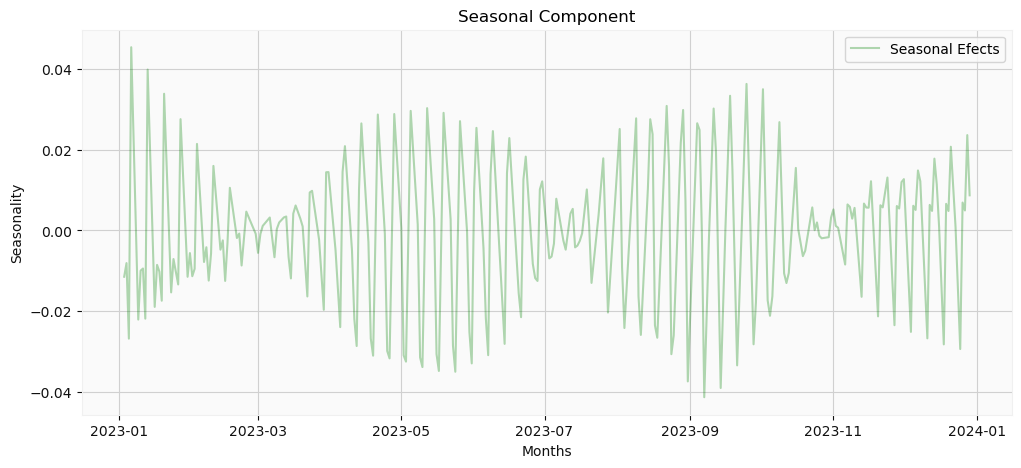

In [9]:
# the seasonal variable from STL decomposition, using it here and plotting the seasonal component's chart
seasonal = result.seasonal

plt.figure(figsize=(12, 5))
plt.plot(stock_prices_standardized.index, seasonal, label="Seasonal Efects", color="green", alpha=0.3)
plt.title("Seasonal Component")
plt.xlabel("Months")
plt.ylabel("Seasonality")
plt.legend()
plt.show()

In [10]:
seasonal = seasonal.to_numpy()

# from the scipy fft docs plotting frequencies per day
n = len(seasonal)
xf = fftfreq(n, d=1)
yf = fft(seasonal)

# considering the frequencies which are the most dominant and ignoring the others to get the 
dominant_frequency = xf[np.argmax(np.abs(yf[1:n//2]))]
# time=t/freq
dominant_period = 1 / dominant_frequency

print(f"Dominant Frequency: {dominant_frequency:.4f} (cycles per day)")
print(f"Dominant Period: {dominant_period:.2f} days")


Dominant Frequency: 0.1468 (cycles per day)
Dominant Period: 6.81 days


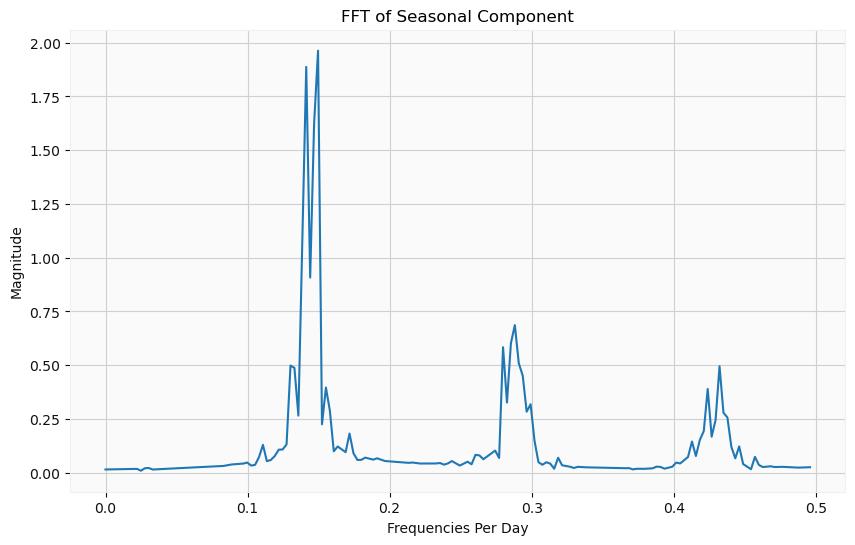

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(xf[:n // 2], np.abs(yf[:n // 2]))
plt.title("FFT of Seasonal Component")
plt.xlabel("Frequencies Per Day")
plt.ylabel("Magnitude")
plt.show()

In [12]:
# using the same model as in trend but changes in cov_func
# considering Periodic intead of ExpQuad
with pm.Model() as seasonal_model:
    # Periodic Kernel
    eta = pm.Gamma("eta", alpha=2, beta=1)
    period = pm.Gamma("period", alpha=2, beta=1)
    ls = pm.Gamma("length_scale", alpha=2, beta=1)
    noise=pm.HalfNormal("noise", sigma=0.1)

    cov_func = eta**2 * pm.gp.cov.Periodic(1, period=period, ls=ls)
    
#     since the data is too big, it takes long for the model to run, so reducing samples and passing it in likelihood
    inducing_points = np.linspace(0, len(seasonal), 50)[:, None]
    
#     considering MarginalSparse since it is faster than Marginal
#     gauss = pm.gp.Marginal(cov_func=kernel)
    gauss = pm.gp.MarginalSparse(cov_func=cov_func, approx="VFE")
    
    likeli = gauss.marginal_likelihood("likeli", X=np.arange(len(seasonal))[:, None], Xu=inducing_points, y=seasonal, noise=noise)
    
    trace = pm.sample(200, tune=100, return_inferencedata=True, nuts_sampler="numpyro", target_accept=0.99)  

C:\Users\eshik\anaconda3\lib\site-packages\pymc\gp\gp.py:898: FutureWarning: gp.MarginalSparse has been renamed to gp.MarginalApprox.
  warnings.warn(
C:\Users\eshik\anaconda3\lib\site-packages\pymc\gp\gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
az.summary(trace, hdi_prob = 0.95)

C:\Users\eshik\anaconda3\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,1.663,1.355,0.012,3.877,0.654,0.498,5.0,31.0,2.82
period,2.920,2.267,1.049,6.710,1.111,0.848,5.0,34.0,2.86
length_scale,3.152,1.343,1.511,5.788,0.555,0.414,8.0,58.0,1.69
noise,0.014,0.001,0.013,0.016,0.000,0.000,7.0,20.0,1.55


In [14]:
with seasonal_model:

    thin_trace = trace.posterior.isel(draw=slice(0, None, 20))
    
    X_new = np.arange(len(seasonal))[:, None]
    gauss_pred = gauss.conditional("gauss_pred", X_new, pred_noise=True)
    samples = pm.sample_posterior_predictive(thin_trace, var_names=["gauss_pred"], predictions=True)
    post_mean = samples.predictions["gauss_pred"].mean(axis=0)
    post_std = samples.predictions["gauss_pred"].std(axis=0)


C:\Users\eshik\AppData\Local\Temp\ipykernel_26208\3622495098.py:7: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  samples = pm.sample_posterior_predictive(thin_trace, var_names=["gauss_pred"], predictions=True)
Sampling: [gauss_pred]


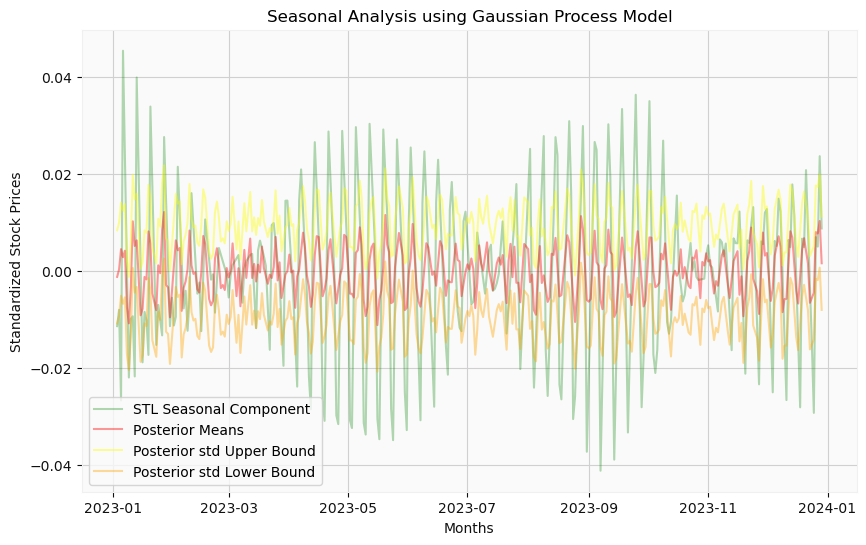

In [15]:
# after fetching the posterior means, plotting it with the STL seasonal component.
# this will show how the model performs for the seasonal data

post_mean = samples.predictions["gauss_pred"].mean(axis=0)
post_mean = post_mean.mean(axis=0)
# post_mean.shape
post_std = post_mean.std(axis=0)
# seasonal.shape

plt.figure(figsize=(10, 6))
plt.plot(stock_prices_standardized.index, seasonal, label="STL Seasonal Component", color="green", alpha=0.3)
plt.plot(stock_prices_standardized.index, post_mean, label="Posterior Means", color="red", alpha = 0.4)
plt.plot(stock_prices_standardized.index, post_mean + 2*post_std, label="Posterior std Upper Bound", color="yellow", alpha = 0.4)
plt.plot(stock_prices_standardized.index, post_mean - 2*post_std, label="Posterior std Lower Bound", color="orange", alpha = 0.4)
plt.title("Seasonal Analysis using Gaussian Process Model")
plt.xlabel("Months")
plt.ylabel("Standardized Stock Prices")
plt.legend()
plt.show()

# Residual Analysis using GARCH Model

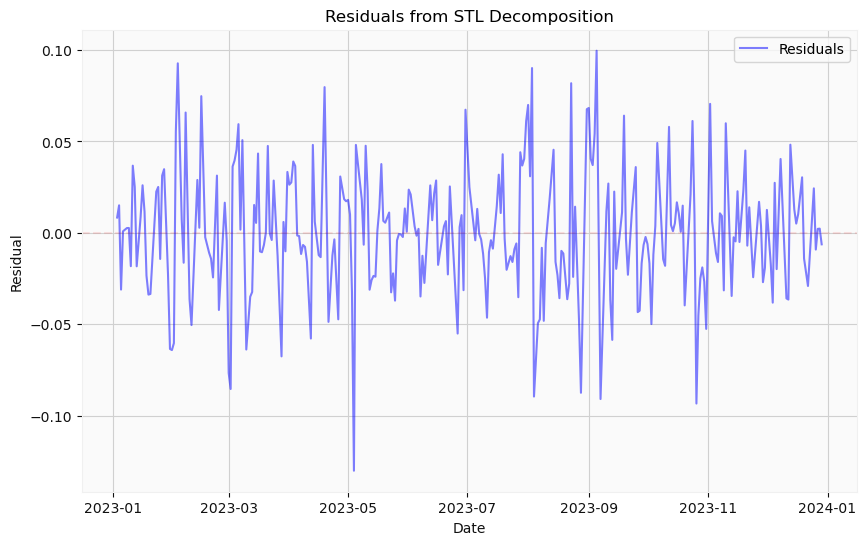

In [16]:
# using the residuals component variable from STL decomposition
residuals = result.resid

# this is the plot for the STL residuals component
plt.figure(figsize=(10, 6))
plt.plot(stock_prices_standardized.index, residuals, label="Residuals", color="blue", alpha=0.5)
plt.axhline(0, color="red", linestyle="--", alpha=0.1)
plt.title("Residuals from STL Decomposition")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

In [17]:
# using the GARCH Model for ploting the residual component
garch_model = arch_model(residuals, vol="Garch", p=1, q=1)
garch_results = garch_model.fit(disp="off")

print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                740.949
Distribution:                  Normal   AIC:                          -1473.90
Method:            Maximum Likelihood   BIC:                          -1458.34
                                        No. Observations:                  361
Date:                Tue, Nov 26 2024   Df Residuals:                      360
Time:                        21:49:37   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.4955e-04  1.859e-03      0.457      0.648 

C:\Users\eshik\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


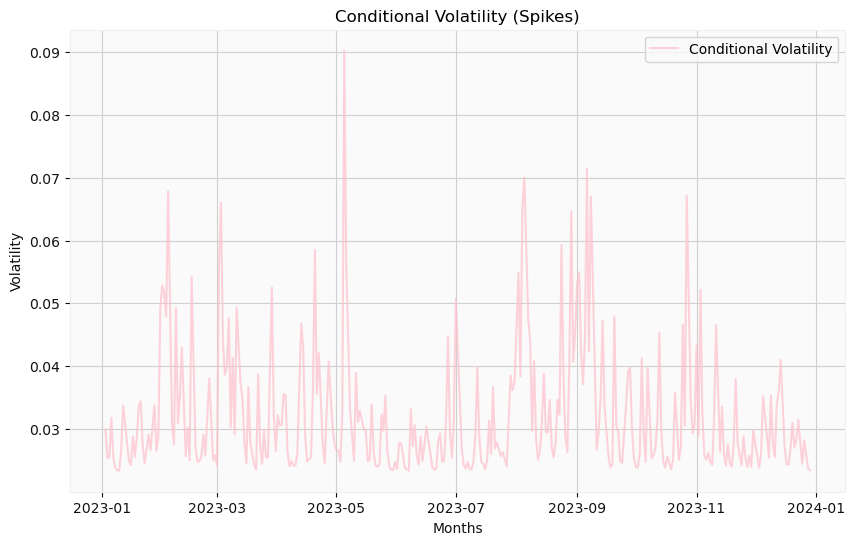

In [18]:
# using the garch model, plotting the residuals which is refered to as conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(stock_prices_standardized.index, garch_results.conditional_volatility, label="Conditional Volatility", color="pink", alpha=0.7)
plt.title("Conditional Volatility (Spikes)")
plt.xlabel("Months")
plt.ylabel("Volatility")
plt.legend()
plt.show()